In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import critical_loads as cl
import rasterio
import warnings
import os
import numpy as np
from IPython.display import display

warnings.simplefilter('ignore')
plt.style.use('ggplot')

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database='critical_loads')

Connection successful.


# Critical loads: Deposition workflow

In Spring 2018, the workflow for calculating critical loads was refined to make use of new, higher-resolution input datasets. During November 2018, data handling for the Critical Loads project was also redesigned, with the ultimate aim of centralising all key datasets on NIVA's new cloud platform. 

This notebook deals with processing, uploading and extracting of deposition data using the new system.

## 1. Organising deposition data on the DSToolkit

NIVA's JupyterHub includes a PostGIS database server capable of storing relational and vector geospatial datasets. I have created a database named `critical_loads` and, within this, a schema named `deposition`. This schema contains the following tables:

 * **dep_grid_0_1deg:** Vector geospatial data representing the new 0.1 degree deposition grid
 
 * **dep_grid_blr:** Vector geospatial data representing the old (pre-2018) "BLR" deposition grid
 
 * **dep_param_defs:** Non-spatial table defining parameters and units for the deposition datasets
 
 * **dep_series_defs:** Non-spatial table defining different data processing "series" (time periods, grid resolutions etc.)
 
 * **dep_values_0_1deg_grid:** Non-spatial table containing deposition values for the 0.1 degree grid (indexed by `series_id`, `cell_id` and `parameter_id`)
 
 * **dep_values_blr_grid:** Non-spatial table containing deposition values for the BLR grid (indexed by `series_id`, `cell_id` and `parameter_id`)

## 2. Add deposition data (optional)

The first step, if desired, is to upload new deposition data for the time period of interest. **You need to connect to the database with admin privileges in order to add/edit data in the database** (use `admin=True` in the `connect_postgis` function above, and then supply a valid username and password).

### 2.1. Define a new deposition series (optional)

The code below shows the existing deposition series already defined in the database.

In [3]:
# Show series already in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)
    display(ser_grid)

,series_id,name,short_name,grid,description
0,1,Middel 1978-1982,7882,blr,Fordelt til BLR av NILU 2002
1,2,Middel 1992-1996,9296,blr,Fordelt til BLR av NILU 2002
2,3,Middel 1997-2001,9701,blr,Fordelt til BLR av NILU 2002
3,4,Middel 2002-2006,0206,blr,Fordelt til BLR av NILU 2008 (Wenche Aas)
4,5,Beregnet 2010,None,None,"Gøteborg protokollen 1999. ""Gamle"""
5,6,Middel 1983-1987,None,None,Tall fra den gamle tålegrensebasen(D_S/N). OBS Verdier omgjort fra g til mg
6,7,Middel 1988-1992,None,None,Tall fra den gamle tålegrensebasen(D-S90) NB kun S.OBS Verdier omgjort fra g til mg
7,8,"2010 (EMEP/CCE 2008) ""his""",None,None,NB: konvertert fra ekv/ha/yr til mekv/m2/yr (/10). 24.10.1010. TOH Her er det noe rart
8,9,"2020 (EMEP/CCE 2008) ""MFR""",None,None,NB: konvertert fra ekv/ha/yr til mekv/m2/yr (/10) 24.10.1010. TOH Her er det noe rart
9,10,"2020 (EMEP/CCE 2008) ""CLE""",None,None,NB: konvertert fra ekv/ha/yr til mekv/m2/yr (/10) 24.10.1010. TOH Her er det noe rart


In [4]:
## Add new series to database. Edit the variables below to define
## a new row and add it to the table
#series_id = 31
#long_name = 'EMEP 1880'
#short_name = 'emep1880'
#grid = 'emep'
#desc = 'Based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes',
#
## Add to table
#cl.add_dep_series(series_id, 
#                  long_name,
#                  short_name,
#                  grid,
#                  desc,   
#                  eng,
#                 )

### 2.2. Upload deposition data (optional)

In 2017, NILU supplied raw data for the 0.1 degree grid in `.dat` format. The code here assumes new data are supplied in the same way.

Modify the user options in the cell below to match your new data:

 * `ser_id` is the ID of the new row that was added to the table above
 
 * `dat_fold` is the *relative* path to a folder containing **only** the `.dat` files you wish to upload

In [5]:
## series_id to upload
#ser_id = 28
#
## Folder containing .dat files
#dat_fold = r'../../../data/raw/nilu_dep/2012-2016'

In [6]:
## Process NILU data and add to db
#df = cl.upload_nilu_0_1deg_dep_data(dat_fold, eng, ser_id)
#df.head()

## 3. Extract deposition data

The code below extracts deposition data for the specified parameter (`nitrogen` or `sulphur`) and `series_id`. Note that, for this to work, the `series_id` must have an entry in the `grid` column of the deposition series table (see section 2.1). The code also performs unit conversions and returns values in $meq/m^2$, $mg/m^2$ and $kg/ha$.

In [7]:
# series_id of interest
series_id = 28

# Get dep data from database
n_gdf = cl.extract_deposition_as_gdf(series_id, 'nitrogen', eng)
s_gdf = cl.extract_deposition_as_gdf(series_id, 'sulphur', eng)

n_gdf.head()

,geom,cell_id,ndep_mgpm2pyr,ndep_meqpm2pyr,ndep_kgphapyr
0,"MULTIPOLYGON (((5655.001 6470694.353, 5514.139...",58050655,840.0,59.957173,8.40
1,"MULTIPOLYGON (((9788.009 6465964.999, 9428.009...",58050665,911.0,65.024982,9.11
2,"MULTIPOLYGON (((17388.726 6469241.096, 17261.7...",58050675,1014.0,72.376874,10.14
3,"MULTIPOLYGON (((22572.274 6462862.544, 22543.7...",58050685,1070.0,76.374019,10.70
4,"MULTIPOLYGON (((27984.320 6458257.535, 27885.2...",58050695,1108.0,79.086367,11.08


## 4. Map deposition data

The code below generates choropleth maps of total N and S deposition for the specified data series.

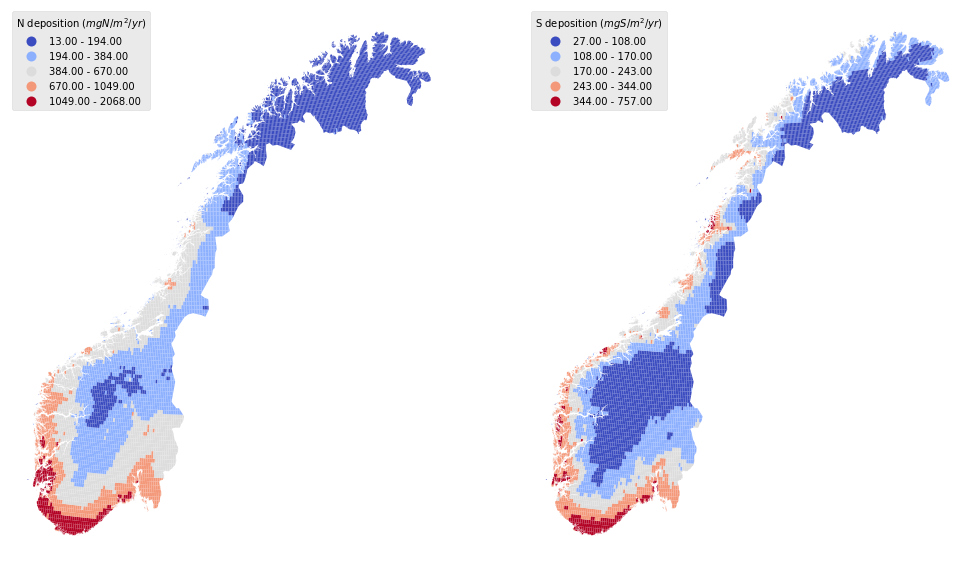

In [8]:
# Choropleth maps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

n_gdf.plot(column='ndep_mgpm2pyr', 
           cmap='coolwarm',
           scheme='fisher_jenks',
           edgecolor=None,
           legend=True,
           legend_kwds={'loc':   'upper left',
                        'title': 'N deposition ($mgN/m^2/yr$)'},
           ax=axes[0],
          )

s_gdf.plot(column='sdep_mgpm2pyr', 
           cmap='coolwarm',
           scheme='fisher_jenks',
           edgecolor=None,
           legend=True,
           legend_kwds={'loc':   'upper left',
                        'title': 'S deposition ($mgS/m^2/yr$)'},
           ax=axes[1],
          )

axes[0].set_axis_off()
axes[1].set_axis_off()
plt.tight_layout()

## 5. Create deposition rasters

The exceedance calculations now use a raster-based workflow. There are two main advantages to this: (i) the calculations are much faster, and (ii) by rasterising to a common grid with a cell size much smaller than the resolution of the original depositioon data, we can easily combine historic datasets - regardless of which vector grid was originally used ("BLR", "0.1 degree", "EMEP" etc.).

The code below creates rasters of N and S deposition at the specified resolution. 60 m or 120 m resolution will be sufficient for most purposes and these options are less computationally intensive. If you wish to use 30 m, **you should log out and sign in again on a "high memory" machine**, as the grids involved are large.

In [9]:
# User choices
series_id = 28
cell_size = 120
unit = 'mgpm2pyr'
pars = ['nitrogen', 'sulphur']

In [10]:
%%time

# Create deposition rasters
for par in pars:
    cl.create_deposition_raster(series_id, par, unit, cell_size, eng, ndv=-1)

CPU times: user 18.8 s, sys: 1.5 s, total: 20.3 s
Wall time: 25.4 s


## 6. Change factors from EMEP data

The code below illustrates how to use the new CL functions to estimate 2030 deposiiton of N and S for Norway using the **delta-change** method (see the issue [here](https://github.com/JamesSample/critical_loads_2/issues/4) for details.

Change factors are calculated by comparing EMEP data for 2010 and 2030, and these are then applied to the NILU dataset for 2007 - 2011.

In [11]:
# Show series in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)
    display(ser_grid)

,series_id,name,short_name,grid,description
0,1,Middel 1978-1982,7882,blr,Fordelt til BLR av NILU 2002
1,2,Middel 1992-1996,9296,blr,Fordelt til BLR av NILU 2002
2,3,Middel 1997-2001,9701,blr,Fordelt til BLR av NILU 2002
3,4,Middel 2002-2006,0206,blr,Fordelt til BLR av NILU 2008 (Wenche Aas)
4,5,Beregnet 2010,None,None,"Gøteborg protokollen 1999. ""Gamle"""
5,6,Middel 1983-1987,None,None,Tall fra den gamle tålegrensebasen(D_S/N). OBS Verdier omgjort fra g til mg
6,7,Middel 1988-1992,None,None,Tall fra den gamle tålegrensebasen(D-S90) NB kun S.OBS Verdier omgjort fra g til mg
7,8,"2010 (EMEP/CCE 2008) ""his""",None,None,NB: konvertert fra ekv/ha/yr til mekv/m2/yr (/10). 24.10.1010. TOH Her er det noe rart
8,9,"2020 (EMEP/CCE 2008) ""MFR""",None,None,NB: konvertert fra ekv/ha/yr til mekv/m2/yr (/10) 24.10.1010. TOH Her er det noe rart
9,10,"2020 (EMEP/CCE 2008) ""CLE""",None,None,NB: konvertert fra ekv/ha/yr til mekv/m2/yr (/10) 24.10.1010. TOH Her er det noe rart


NILU 2007 - 2011 is series ID 25. EMEP 2010 and 2030 have IDs 57 and 59, respectively.

In [12]:
# Export rasters of interest in mg/m2/yr
series_ids = [25, 57, 59]
cell_size = 120
unit = 'mgpm2pyr'
pars = ['nitrogen', 'sulphur']

for par in pars:
    for series_id in series_ids:
        cl.create_deposition_raster(series_id, 
                                    par, unit, 
                                    cell_size, 
                                    eng, 
                                    ndv=-1, 
                                    veg_class='grid average',
                                   )

The code below applies the delta-change method. It's a little more complicated than strictly necessary, as each dataset is processed in block to keep memory consumption low. An alternative would be to simply sign-in on a more powerful machine, in which case the `block` loop below could be removed.

In [13]:
# Output location
data_fold = r'/home/jovyan/shared/critical_loads/raster/deposition'

# Loop over pars
for par in pars:
    # Paths
    base_path = os.path.join(data_fold, f'{par[0]}dep_mgpm2pyr_0711_120m.tif')
    emep2010_path = os.path.join(data_fold, f'{par[0]}dep_mgpm2pyr_emep2010_120m.tif')
    emep2030_path = os.path.join(data_fold, f'{par[0]}dep_mgpm2pyr_emep2030_120m.tif')
    
    # Datasets
    base_src = rasterio.open(base_path)
    emep2010_src = rasterio.open(emep2010_path)
    emep2030_src = rasterio.open(emep2030_path)
    
    # Create output dataset
    prof = base_src.profile
    out_tif = os.path.join(data_fold, f'{par[0]}dep_mgpm2pyr_pred2030_120m.tif')
    out_dst = rasterio.open(out_tif, 'w', **prof)
    
    # Process in blocks to conserve memory
    for block_index, window in base_src.block_windows(1):
        # Read block
        base_block = base_src.read(window=window).astype(float)
        emep2010_block = emep2010_src.read(window=window).astype(float)
        emep2030_block = emep2030_src.read(window=window).astype(float)

        # Set NoData to NaN
        base_block[base_block==-1] = np.nan
        emep2010_block[emep2010_block==-1] = np.nan
        emep2030_block[emep2030_block==-1] = np.nan
        
        # Apply delta-change method
        pred2030_block = base_block * emep2030_block / emep2010_block

        # Set NaN to -1
        pred2030_block = np.nan_to_num(pred2030_block, nan=-1)
        
        out_dst.write(pred2030_block.astype(rasterio.int16), window=window)

    # Tidy up
    base_src.close()
    emep2010_src.close()
    emep2030_src.close()
    out_dst.close()